## Importing Required Libraries and Setting Up

In this section, we import essential libraries for data manipulation, visualization, and statistical analysis. These tools form the backbone of our exploratory data analysis (EDA).

- **pandas**: For data manipulation and analysis.
- **numpy**: For numerical computations.
- **matplotlib** & **seaborn**: For visualizing data.
- **scipy.stats**: For performing statistical tests like t-test and ANOVA.
- **statsmodels**: For more advanced statistical tests (Tukey HSD).
- **plotly.express**: For interactive visualizations.

We also set global styles for `matplotlib` and `seaborn` to ensure consistent and aesthetic plots.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import plotly.express as px

# Set the style for visualizations
plt.style.use('ggplot')
sns.set(style="whitegrid")

## Loading the MovieLens 1M Dataset

We define the file paths for the `movies`, `ratings`, and `users` datasets from the MovieLens 1M dataset. The files are in `.dat` format and use `::` as a separator, so we specify the separator and encoding when reading the files into Pandas DataFrames.

In [2]:
movies_path = r"C:\\Users\\MelvanderMeij\\OneDrive - Finn it\\Bureaublad\\School MDDB\\SDM\\movielens-1m-dataset\\versions\\1\\movies.dat"
ratings_path = r"C:\\Users\\MelvanderMeij\\OneDrive - Finn it\\Bureaublad\\School MDDB\\SDM\\movielens-1m-dataset\\versions\\1\\ratings.dat"
users_path = r"C:\\Users\\MelvanderMeij\\OneDrive - Finn it\\Bureaublad\\School MDDB\\SDM\\movielens-1m-dataset\\versions\\1\\users.dat"

# Reading data with correct encoding and separators
movies = pd.read_csv(movies_path, sep='::', engine='python', header=None, encoding='latin-1', names=['MovieID', 'Title', 'Genres'])
ratings = pd.read_csv(ratings_path, sep='::', engine='python', header=None, encoding='latin-1', names=['UserID', 'MovieID', 'Rating', 'Timestamp'])
users = pd.read_csv(users_path, sep='::', engine='python', header=None, encoding='latin-1', names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])


## Data Dictionary

### Users Dataset (`users.dat`)
| Column Name | Description |
|-------------|-------------|
| UserID      | Unique ID for each user |
| Gender      | User gender (M/F) |
| Age         | Age category (encoded) |
| Occupation  | Occupation ID (encoded) |
| Zip-code    | User’s zip-code |

### Movies Dataset (`movies.dat`)
| Column Name | Description |
|-------------|-------------|
| MovieID     | Unique ID for each movie |
| Title       | Movie title (year of release in brackets) |
| Genres      | Pipe-separated list of genres associated with the movie |

### Ratings Dataset (`ratings.dat`)
| Column Name | Description |
|-------------|-------------|
| UserID      | ID of the user who rated the movie |
| MovieID     | ID of the movie rated |
| Rating      | Explicit rating given by the user (1 to 5) |
| Timestamp   | Time when the rating was given (Unix time) |


## Mapping User Occupations to Descriptive Labels

The `users` dataset includes an `Occupation` column coded as integers. To make this data more interpretable, we map these codes to their respective occupation descriptions.


In [3]:
occupation_mapping = {
    0: "other/not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
    4: "college/grad student", 5: "customer service", 6: "doctor/health care",
    7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student",
    11: "lawyer", 12: "programmer", 13: "retired", 14: "sales/marketing",
    15: "scientist", 16: "self-employed", 17: "technician/engineer",
    18: "tradesman/craftsman", 19: "unemployed", 20: "writer"
}

# Apply occupation mapping
users['OccupationDesc'] = users['Occupation'].map(occupation_mapping)

>Now, the `users` DataFrame includes a readable `OccupationDesc` column that makes it easier to understand the demographics.

## Mapping User Ages to Descriptive Categories

The `users` dataset contains an `Age` column with numeric values representing age ranges. To enhance interpretability, we map these numeric values to descriptive age groups.


In [4]:
# Users Age Mapping
age_mapping = {
    1: "Under 18", 18: "18-24", 25: "25-34",
    35: "35-44", 45: "45-49", 50: "50-55", 56: "56+"
}

# Apply age mapping
users['AgeDesc'] = users['Age'].map(age_mapping)

age_order = ['Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+']

# Preview users data
users.head()

,UserID,Gender,Age,Occupation,Zip-code,OccupationDesc,AgeDesc
0,1,F,1,10,48067,K-12 student,Under 18
1,2,M,56,16,70072,self-employed,56+
2,3,M,25,15,55117,scientist,25-34
3,4,M,45,7,02460,executive/managerial,45-49
4,5,M,25,20,55455,writer,25-34


> The `users` DataFrame now includes a `AgeDesc` column with clearly labeled age categories, making demographic analysis more intuitive.


## Merging Datasets for Unified Analysis

To perform comprehensive analysis, we merge the `ratings` dataset with both `users` and `movies` datasets.  
This unified dataset allows us to analyze user ratings in the context of demographics and movie genres.

In [5]:
# Merge ratings with user and movie information
ratings = ratings.merge(users, on='UserID', how='left')
ratings = ratings.merge(movies, on='MovieID', how='left')

# Preview merged ratings data
ratings.head()

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,OccupationDesc,AgeDesc,Title,Genres
0,1,1193,5,978300760,F,1,10,48067,K-12 student,Under 18,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,F,1,10,48067,K-12 student,Under 18,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,F,1,10,48067,K-12 student,Under 18,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,F,1,10,48067,K-12 student,Under 18,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,F,1,10,48067,K-12 student,Under 18,"Bug's Life, A (1998)",Animation|Children's|Comedy


>The merged `ratings` DataFrame now includes movie titles, genres, and user demographic information.  
This consolidated view is essential for meaningful exploratory analysis.


## Converting Timestamps to Readable Dates

The `ratings` dataset includes a `Timestamp` column representing the time each rating was made (in Unix epoch format).  
We convert these timestamps into human-readable `datetime` objects for easier temporal analysis.

In [6]:
# Convert timestamp to datetime
ratings['RatingDate'] = pd.to_datetime(ratings['Timestamp'], unit='s')

# Preview the updated DataFrame
ratings[['Timestamp', 'RatingDate']].head()

,Timestamp,RatingDate
0,978300760,2000-12-31 22:12:40
1,978302109,2000-12-31 22:35:09
2,978301968,2000-12-31 22:32:48
3,978300275,2000-12-31 22:04:35
4,978824291,2001-01-06 23:38:11


>Now, each rating has an associated `RatingDate`, allowing us to explore time-based trends in user behavior.

## Distribution of Movie Ratings

Let's start by exploring the distribution of movie ratings in the dataset.  
This will give us a general idea of how users rate movies—whether ratings are mostly positive, negative, or neutral.

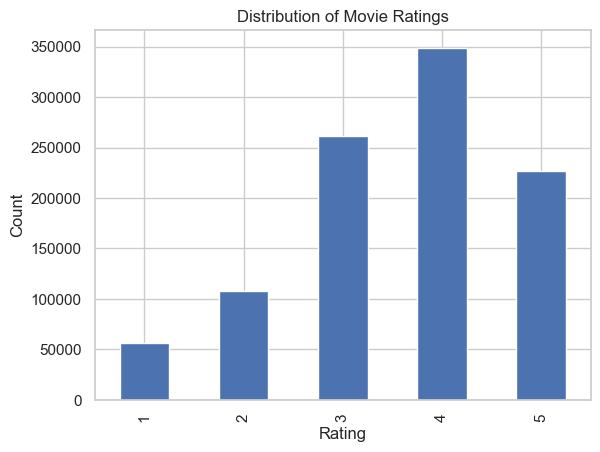

In [7]:
# Distribution of Ratings
ratings['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

> The ratings distribution is skewed towards higher scores, with a majority of ratings being 3 and 4.  
This suggests users are generally more positive in their ratings, a common trend in explicit feedback datasets. 

In [8]:
# Number of ratings per user
user_rating_counts = ratings.groupby('UserID')['Rating'].count()

# Basic stats
user_rating_counts.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
Name: Rating, dtype: float64

## User Activity Analysis
- Users have rated between **20 and 2,000** movies.
- The **average number of ratings per user is ~165**.
- Heavy users (power raters) may have different preferences or behaviors from casual users.

### Implications
For collaborative filtering (UserKNN), **active users** will have more reliable similarity profiles.  
For less active users, **hybrid or content-based methods** may be necessary.


In [9]:
# Number of ratings per movie
movie_rating_counts = ratings.groupby('MovieID')['Rating'].count()

# Basic stats
movie_rating_counts.describe()

count    3706.000000
mean      269.889099
std       384.047838
min         1.000000
25%        33.000000
50%       123.500000
75%       350.000000
max      3428.000000
Name: Rating, dtype: float64

## Item (Movie) Popularity Analysis
- Movies have between **1 and 3,400** ratings.
- The **most-rated movies** include blockbusters and popular classics.
- Some movies are **sparsely rated**, which can make similarity calculations less reliable.

### Implications
- **ItemKNN** models should **handle popularity bias** (frequent items dominate similarities).  
- **SVD++** can manage data sparsity better through **latent factors**, giving niche items better exposure.


## Calculating Average Rating and Number of Ratings per Movie

To understand which movies are most rated and how they are perceived,  
we calculate the average rating and the total number of ratings for each movie.

In [10]:
# Average rating per movie
movie_ratings = ratings.groupby('Title')['Rating'].agg(['mean', 'count']).reset_index()

# Preview the top movies by number of ratings
movie_ratings.sort_values('count', ascending=False).head(10)

,Title,mean,count
127,American Beauty (1999),4.317386,3428
3153,Star Wars: Episode IV - A New Hope (1977),4.453694,2991
3154,Star Wars: Episode V - The Empire Strikes Back...,4.292977,2990
3155,Star Wars: Episode VI - Return of the Jedi (1983),4.022893,2883
1789,Jurassic Park (1993),3.763847,2672
2894,Saving Private Ryan (1998),4.337354,2653
3293,Terminator 2: Judgment Day (1991),4.058513,2649
2112,"Matrix, The (1999)",4.315830,2590
258,Back to the Future (1985),3.990321,2583
2990,"Silence of the Lambs, The (1991)",4.351823,2578


>This table shows the top 10 movies with the highest number of ratings,  
along with their average ratings. These tend to be popular and widely viewed titles.


## Analyzing Average Movie Ratings by Gender

Here, we explore potential differences in rating behaviors between male and female users.  
We calculate the average rating given by each gender.

In [11]:
# Average rating by gender
ratings.groupby('Gender')['Rating'].mean()

Gender
F    3.620366
M    3.568879
Name: Rating, dtype: float64

>Female users gave slightly higher average ratings (3.62) compared to male users (3.57).


## Analyzing Average Movie Ratings by Age Group

Next, we analyze how different age groups rate movies on average.  
This can reveal preferences or rating tendencies across age demographics.

In [12]:
# Average rating by age group
ratings.groupby('AgeDesc')['Rating'].mean()

AgeDesc
18-24       3.507573
25-34       3.545235
35-44       3.618162
45-49       3.638062
50-55       3.714512
56+         3.766632
Under 18    3.549520
Name: Rating, dtype: float64

>The results give insights into which age groups tend to give higher or lower ratings overall.


## Analyzing Average Movie Ratings by Occupation

We further explore how occupation influences movie ratings by calculating  
the average rating from users in each occupation category.

In [13]:
# Average rating by occupation
ratings.groupby('OccupationDesc')['Rating'].mean().sort_values(ascending=False)

OccupationDesc
retired                 3.781736
scientist               3.689774
doctor/health care      3.661578
homemaker               3.656589
clerical/admin          3.656516
programmer              3.654001
sales/marketing         3.618481
lawyer                  3.617371
technician/engineer     3.613574
executive/managerial    3.599772
self-employed           3.596575
academic/educator       3.576642
artist                  3.573081
other/not specified     3.537544
customer service        3.537529
college/grad student    3.536793
K-12 student            3.532675
tradesman/craftsman     3.530117
writer                  3.497392
farmer                  3.466741
unemployed              3.414050
Name: Rating, dtype: float64

>This ranking provides an interesting look at how different professional groups rate movies—  
some may be more critical, while others are more generous.


## Visualizing Rating Distribution by Gender

To explore potential differences in rating behavior between genders, we use two types of visualizations: a boxplot with the mean overlaid and a density plot. These visuals help us compare not only the spread and central tendency but also the overall distribution shape of ratings by gender.

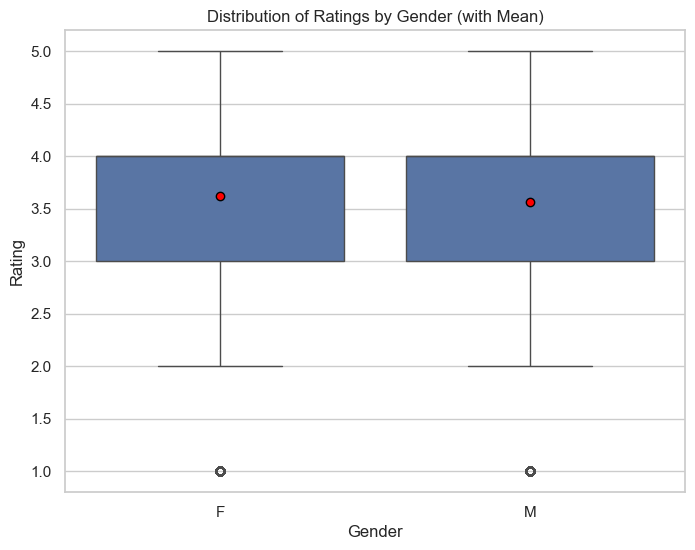

In [14]:
# Boxplot of ratings by gender
plt.figure(figsize=(8, 6))
sns.boxplot(x='Gender', y='Rating', data=ratings, showmeans=True,
            meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"},
            meanline=False)
plt.title('Distribution of Ratings by Gender (with Mean)')
plt.show()

> The boxplot shows the distribution of ratings for each gender, including median, quartiles, and outliers.  
The red dot represents the **mean rating**, revealing that female users give slightly higher ratings on average than male users, even though the medians and spread appear similar.

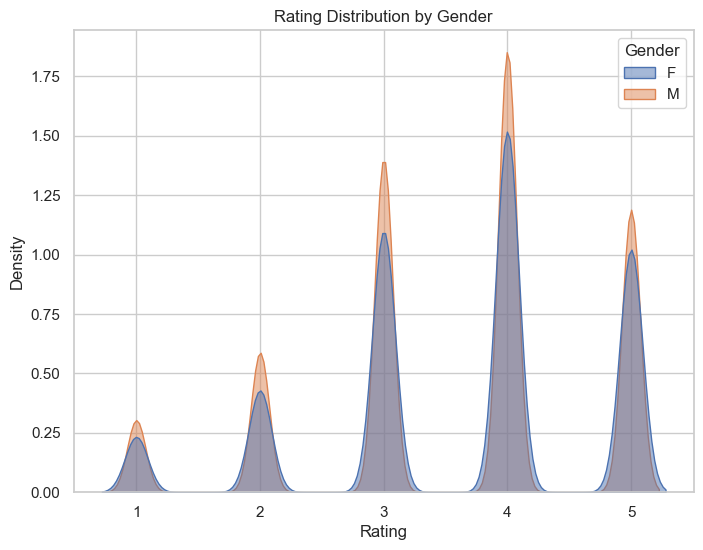

In [15]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=ratings, x='Rating', hue='Gender', fill=True, common_norm=False, alpha=0.5)
plt.title('Rating Distribution by Gender')
plt.show()

> This plot shows the smoothed distribution of ratings for both genders.  
The density is estimated using **Kernel Density Estimation (KDE)**, which creates a smooth curve representing the probability distribution of ratings.  
It reveals a small shift indicating that **female users tend to rate slightly higher on average** than male users, despite overall similar patterns.

## Statistical Test: T-Test for Gender-Based Ratings

After visualizing rating distributions by gender,  
we conduct an independent T-test to determine if the difference in average ratings between male and female users is statistically significant.

In [16]:
# Separate ratings by gender
male_ratings = ratings[ratings['Gender'] == 'M']['Rating']
female_ratings = ratings[ratings['Gender'] == 'F']['Rating']

# Perform independent T-test
ttest_result = ttest_ind(male_ratings, female_ratings)

print("T-Test Results (Male vs Female Ratings):")
print(f"Statistic: {ttest_result.statistic:.4f}")
print(f"P-Value: {ttest_result.pvalue:.4f}")

if ttest_result.pvalue < 0.05:
    print("The difference in ratings by gender is statistically significant.")
else:
    print("No statistically significant difference in ratings by gender.")

T-Test Results (Male vs Female Ratings):
Statistic: -19.8666
P-Value: 0.0000
The difference in ratings by gender is statistically significant.


> The T-Test reveals a **statistically significant difference** between male and female ratings (p < 0.05).  
> However, the actual difference in mean ratings is very small (~0.05), meaning that **while statistically significant, it is likely not practically significant** for building recommender systems.  
> Therefore, gender alone may not be a strong predictive feature, and recommendation models should focus more on **user-item interactions**.


## Visualizing Rating Distribution by Age Group

We extend our analysis to age groups by plotting a boxplot.  
This helps reveal differences in rating behaviors across various age categories.

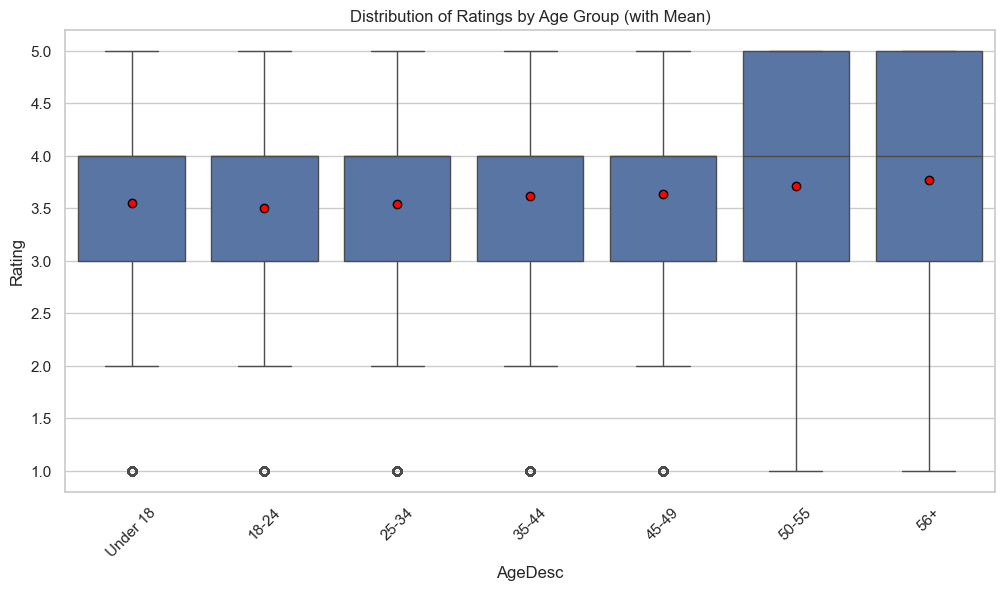

In [17]:
# Boxplot with correct order and mean
plt.figure(figsize=(12, 6))
sns.boxplot(x='AgeDesc', y='Rating', data=ratings, order=age_order, showmeans=True,
            meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"})
plt.title('Distribution of Ratings by Age Group (with Mean)')
plt.xticks(rotation=45)
plt.show()

> The boxplot shows that users in the **50–55** and **56+** age groups have slightly higher mean ratings, as indicated by the red dots.  
> However, the overall rating spread is similar across age groups, with all medians around 4 and outliers present in each group.

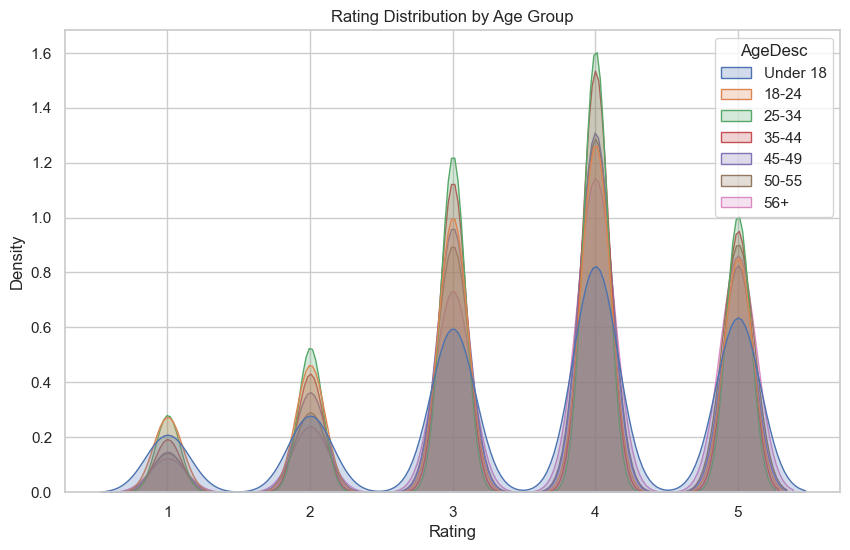

In [18]:
# KDE Plot (Rating Distributions)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=ratings, x='Rating', hue='AgeDesc', common_norm=False, hue_order= age_order, fill=True, alpha=0.25)
plt.title('Rating Distribution by Age Group')
plt.show()

> The KDE plot visualizes smoothed rating distributions using **Kernel Density Estimation (KDE)**.  
> It shows that all age groups follow a similar pattern, with subtle shifts suggesting that **older users (50–55, 56+)** lean slightly more toward higher ratings compared to younger groups.

## Statistical Test: ANOVA for Ratings by Age Group

We use a one-way ANOVA test to check if there are significant differences in average ratings between different age groups.

In [19]:
# Create list of ratings by age group
age_groups = ratings['AgeDesc'].unique()
ratings_by_age = [ratings[ratings['AgeDesc'] == age]['Rating'] for age in age_groups]

# Perform ANOVA
anova_result = f_oneway(*ratings_by_age)

print("ANOVA Results (Ratings by Age Group):")
print(f"Statistic: {anova_result.statistic:.4f}")
print(f"P-Value: {anova_result.pvalue:.4f}")

if anova_result.pvalue < 0.05:
    print("There is a statistically significant difference in ratings between age groups.")
else:
    print("No statistically significant difference in ratings between age groups.")

ANOVA Results (Ratings by Age Group):
Statistic: 629.7827
P-Value: 0.0000
There is a statistically significant difference in ratings between age groups.


> The ANOVA test confirms a **statistically significant difference** in ratings across age groups (p < 0.05).  
> Age group segmentation might improve **cold-start** recommendations for new users if integrated into a hybrid system.

## Visualizing Rating Distribution by Occupation

We now analyze how different occupations affect movie ratings by plotting a boxplot.  
This provides a detailed view of rating distributions across professional groups.

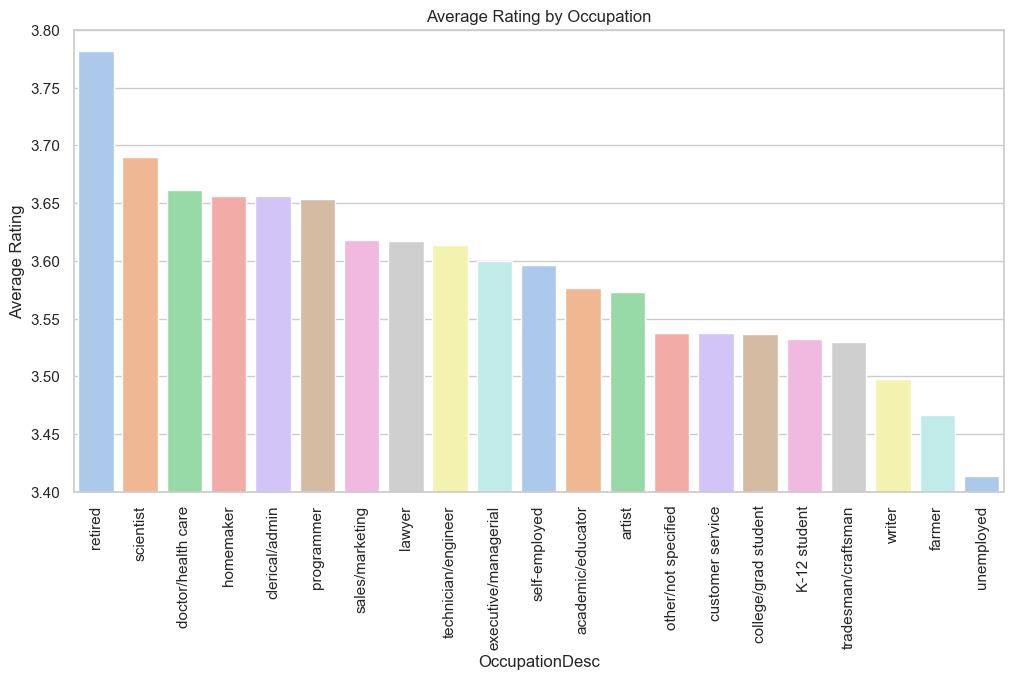

In [20]:
# Calculate mean ratings per occupation and sort
mean_ratings = ratings.groupby('OccupationDesc')['Rating'].mean().sort_values(ascending=False)

# Barplot
plt.figure(figsize=(12, 6))
sns.barplot(x=mean_ratings.index, y=mean_ratings.values, hue=mean_ratings.index, dodge=False, palette='pastel', legend=False)
plt.title('Average Rating by Occupation')
plt.ylabel('Average Rating')
plt.xticks(rotation=90)
plt.ylim(3.4, 3.8)
plt.show()

> The barplot reveals subtle but notable differences in average movie ratings by occupation.  
> **Retired individuals, scientists, and healthcare professionals** gave the highest average ratings, while **writers, farmers, and unemployed users** rated movies the lowest on average.  
> These differences could offer valuable signals for **cold-start user profiles** in hybrid recommender systems.

## Statistical Analysis: Ratings by Occupation

We want to determine if movie ratings vary across different occupations.
To do this, we first perform a one-way ANOVA to check whether there is a statistically significant difference in average ratings between occupation groups.

If the ANOVA indicates significant differences, we follow up with Tukey’s Honest Significant Difference (HSD) test to identify which specific groups differ.

In [21]:
# Group ratings by occupation
occupation_groups = ratings['OccupationDesc'].unique()
ratings_by_occ = [ratings[ratings['OccupationDesc'] == occ]['Rating'] for occ in occupation_groups]

# Perform ANOVA
anova_occ_result = f_oneway(*ratings_by_occ)

print("ANOVA Results (Ratings by Occupation):")
print(f"Statistic: {anova_occ_result.statistic:.4f}")
print(f"P-Value: {anova_occ_result.pvalue:.4f}")

# Perform Tukey HSD only if ANOVA is significant
if anova_occ_result.pvalue < 0.05:
    print("\nTukey HSD Results:")
    tukey_result = pairwise_tukeyhsd(endog=ratings['Rating'],
                                     groups=ratings['OccupationDesc'],
                                     alpha=0.05)
    print(tukey_result)
else:
    print("No significant differences found between occupation groups. Tukey HSD skipped.")

ANOVA Results (Ratings by Occupation):
Statistic: 134.4215
P-Value: 0.0000

Tukey HSD Results:
              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
       group1               group2        meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------
        K-12 student    academic/educator    0.044    0.0  0.0145  0.0734   True
        K-12 student               artist   0.0404 0.0009  0.0088   0.072   True
        K-12 student       clerical/admin   0.1238    0.0  0.0895  0.1582   True
        K-12 student college/grad student   0.0041    1.0 -0.0242  0.0324  False
        K-12 student     customer service   0.0049    1.0 -0.0326  0.0424  False
        K-12 student   doctor/health care   0.1289    0.0  0.0956  0.1622   True
        K-12 student executive/managerial   0.0671    0.0  0.0383  0.0959   True
        K-12 student               farmer  -0.0659 0.3015 -0.1468  0.0149  False
        K-12 s

> An ANOVA test confirms that average movie ratings differ significantly across occupation groups (F = 134.42, p < 0.001).
>To pinpoint where these differences occur, Tukey’s HSD test reveals statistically significant differences between many occupation pairs.
>This indicates that occupation could improve user profiling in user-based collaborative filtering, especially in cold-start scenarios.
>In contrast, models like SVD++, which infer preferences from user behavior, may gain less from occupation data unless it is explicitly incorporated as side information.

## Analyzing Average Ratings by Movie Genre

To explore genre preferences, we first **split the `Genres` column** in the `movies` dataset (which contains multiple genres separated by `|`) using the `explode()` function.  
We then **remove any existing `Genres` column** from the merged `ratings` dataset to avoid duplication, and merge again with the cleaned, exploded genre data.

This allows us to calculate the **average rating per genre** with clean and consistent data.

In [22]:
# Prepare the genres column for merging
movies_genres = movies.copy()
movies_genres['Genres'] = movies_genres['Genres'].str.split('|')
movies_genres = movies_genres.explode('Genres')

# Drop any existing 'Genres' to avoid conflicts
ratings_clean = ratings.drop(columns=['Genres'])

# Merge exploded genres with ratings
ratings_genres = ratings_clean.merge(
    movies_genres[['MovieID', 'Genres']],
    on='MovieID',
    how='left'
)

# Average rating per genre
ratings_genres.groupby('Genres')['Rating'].mean().sort_values(ascending=False)

Genres
Film-Noir      4.075188
Documentary    3.933123
War            3.893327
Drama          3.766332
Crime          3.708679
Animation      3.684868
Mystery        3.668102
Musical        3.665519
Western        3.637770
Romance        3.607465
Thriller       3.570466
Comedy         3.522099
Action         3.491185
Adventure      3.477257
Sci-Fi         3.466521
Fantasy        3.447371
Children's     3.422035
Horror         3.215013
Name: Rating, dtype: float64

> The results reveal that **Film-Noir, Documentary, and War** are the highest-rated genres on average,  
while **Horror, Children’s, and Fantasy** receive the lowest average ratings.  
This clean genre breakdown gives a reliable view of audience preferences across genres.

## Counting the Number of Ratings per Genre

To assess the popularity of each movie genre,
we calculate how many ratings each genre has received after exploding multi-genre entries.
This highlights user engagement and overall interest across genres.

In [23]:
# Number of ratings per genre
ratings_genres.groupby('Genres')['Rating'].count().sort_values(ascending=False)

Genres
Comedy         356580
Drama          354529
Action         257457
Thriller       189680
Sci-Fi         157294
Romance        147523
Adventure      133953
Crime           79541
Horror          76386
Children's      72186
War             68527
Animation       43293
Musical         41533
Mystery         40178
Fantasy         36301
Western         20683
Film-Noir       18261
Documentary      7910
Name: Rating, dtype: int64

>The resulting list shows which genres attract the most user ratings,
giving insight into genre popularity and audience engagement levels.
Comedy, Drama, and Action dominate in volume, suggesting they are the most widely consumed genres.

## Analyzing Genre Preferences by Gender & Age

To understand how different demographic groups perceive movie genres,
we calculate the average rating per genre, first split by gender, then by age group.
This helps identify which genres are favored by whom, offering valuable input for personalized recommendations.

In [24]:
# Average rating by genre and gender
ratings_genre_gender = ratings_genres.groupby(['Genres', 'Gender'])['Rating'].mean().unstack()
ratings_genre_gender

Gender,F,M
Genres,,
Action,3.490252,3.491386
Adventure,3.512879,3.468125
Animation,3.744702,3.661335
Children's,3.572548,3.358961
Comedy,3.571938,3.503667
Crime,3.689332,3.713720
Documentary,3.946392,3.928811
Drama,3.765662,3.766589
Fantasy,3.513076,3.426603


In [25]:
# Average rating by genre and gender
ratings_genre_age = ratings_genres.groupby(['Genres', 'AgeDesc'])['Rating'].mean().unstack()
ratings_genre_age = ratings_genre_age[age_order]
ratings_genre_age

AgeDesc,Under 18,18-24,25-34,35-44,45-49,50-55,56+
Genres,,,,,,,
Action,3.506385,3.447097,3.453358,3.538107,3.528543,3.611333,3.610709
Adventure,3.449975,3.408525,3.443163,3.515291,3.528963,3.628163,3.649064
Animation,3.476113,3.624014,3.701228,3.740545,3.734856,3.780020,3.756233
Children's,3.241642,3.294257,3.426873,3.518423,3.527593,3.556555,3.621822
Comedy,3.497491,3.460417,3.490385,3.561984,3.591789,3.646868,3.650949
Crime,3.710170,3.668054,3.680321,3.733736,3.750661,3.810688,3.832549
Documentary,3.730769,3.865865,3.946690,3.953747,3.966521,3.908108,3.961538
Drama,3.794735,3.721930,3.726428,3.782512,3.784356,3.878415,3.933465
Fantasy,3.317647,3.353778,3.452484,3.482301,3.532468,3.581570,3.532700


> The breakdown by gender shows that genres like Animation, Musical, and Children’s tend to be rated higher by female users,
while Action, Sci-Fi, and Western appeal slightly more to male users.
When looking at age groups, we see a clear trend where older age groups tend to rate most genres higher,
particularly Film-Noir, Drama, and Documentary.
Younger viewers rate Horror and Thriller relatively higher compared to other genres.
These insights can inform demographic-aware recommenders by adjusting genre preferences according to user segments.
For example, a hybrid system could use this data for cold-start scenarios or as part of item similarity weighting in ItemKNN.

## Visualizing Genre Ratings by Gender and Age Using Heatmaps

We use heatmaps to visualize the average movie ratings by genre, segmented by gender and age group.
This allows us to easily detect patterns in genre preferences across different user demographics.

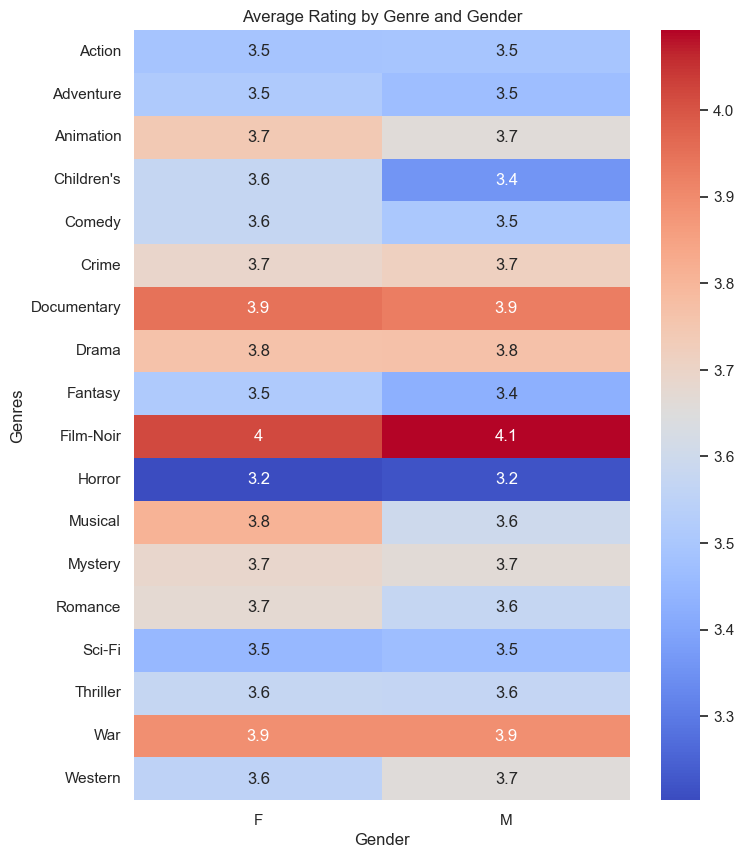

In [26]:
# Heatmap of ratings by genre and gender
plt.figure(figsize=(8, 10))
sns.heatmap(ratings_genre_gender, annot=True, cmap='coolwarm')
plt.title('Average Rating by Genre and Gender')
plt.show()

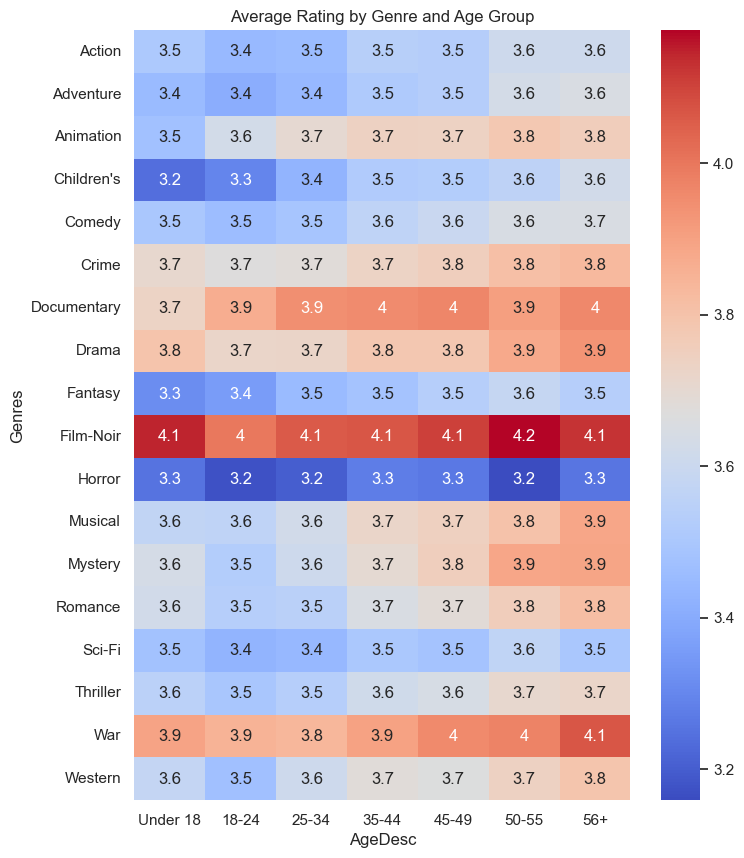

In [27]:
# # Heatmap of ratings by genre and age group
plt.figure(figsize=(8, 10))
sns.heatmap(ratings_genre_age, annot=True, cmap='coolwarm')
plt.title('Average Rating by Genre and Age Group')
plt.show()

> These visualizations reveal demographic-specific preferences across genres.
For example, Musicals and Animation are more favored by female users, while Action and Sci-Fi trend higher among males.
Similarly, older users tend to rate genres like War, Drama, and Film-Noir higher than younger users.
These patterns can be leveraged to improve cold-start recommendations and to fine-tune hybrid filtering models with demographic-aware personalization.

## Tracking Average Ratings Over Time

We examine how the average rating has changed over time.  
By extracting the year from the rating date, we can visualize temporal trends in user ratings.

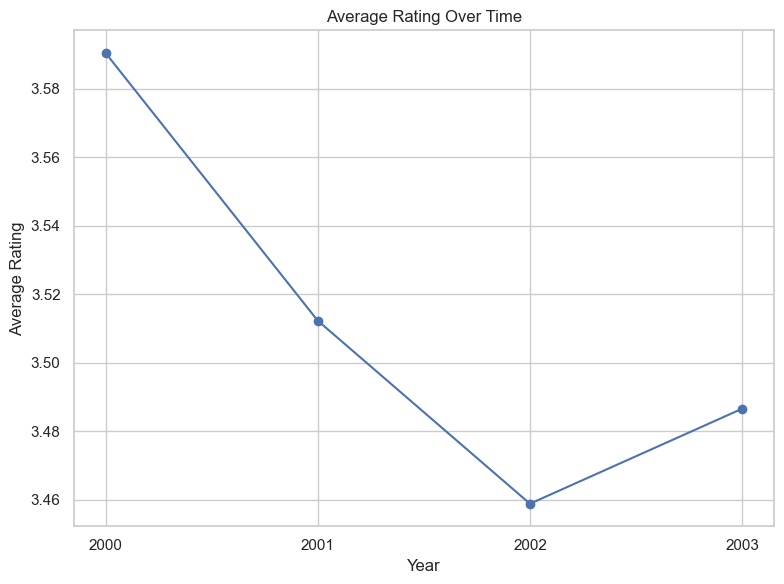

In [32]:
# Extract year from date
ratings['RatingYear'] = ratings['RatingDate'].dt.year

# Group and plot
avg_rating_by_year = ratings.groupby('RatingYear')['Rating'].mean()

plt.figure(figsize=(8, 6))
plt.plot(avg_rating_by_year.index, avg_rating_by_year.values, marker='o')
plt.title('Average Rating Over Time')
plt.xlabel('Year')
plt.ylabel('Average Rating')

# Set x-axis to show integer years only
plt.xticks(avg_rating_by_year.index) 

plt.grid(True)
plt.tight_layout()
plt.show()

> There is a slight decline in average ratings over time, which might indicate **changes in user expectations or rating behavior**.  
Time-based effects should be modeled explicitly in SVD++ using temporal biases or in time-aware KNN approaches to account for evolving user preferences.

## EDA Insights and Implications for Recommender System Modeling

The EDA provided key insights that directly inform our recommender system design:
- **User Demographics**: While demographic differences exist, their predictive power is limited for collaborative filtering models. Demographics may be better suited for cold-start strategies.
- **Genre Preferences**: Strong indicators of user preferences, suggesting **genre-based filtering** could improve both UserKNN and ItemKNN recommendations.
- **Temporal Effects**: Indicate the need for **time-aware models**, potentially enhancing SVD++ performance by incorporating temporal biases.
- **Positive Rating Bias**: Suggests normalizing user ratings or implementing baseline predictors to offset systematic rating inflation.

These findings will guide the implementation and tuning of **SVD++, UserKNN, and ItemKNN models** in the next phase.

In [33]:
# In your EDA notebook
ratings.to_csv('combined_ratings.csv', index=False)